## Final Project: Simulation and Evaluation of the BB84 Quantum Key Distribution Protocol

### Group Members: 
#### **- Ayawa  Sidoinette SOWOU - asx33@hi.is**
#### **- Silja Rós Svansdóttir Þormar - srs60@hi.is**

In [19]:
%matplotlib inline

### Imports: 

In [ ]:
# Imports and Requirements 
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from qiskit.visualization import plot_histogram
from tqdm import tqdm

# For nicer plotting
plt.rcParams.update({'figure.max_open_warning': 0})

# Simulation parameters
NUM_QUBITS = 100            # number of qubits per trial
EAVESDROP_PROBS = [0.0, 0.1, 0.2, 0.3, 0.5]  # probabilities of Eve intercepting
NOISE_PROB = 0.05           # per-qubit random Pauli error probability for channel
TRIALS_PER_POINT = 20       # number of trials per eavesdrop prob, for averaging

# The backend 
BACKEND = AerSimulator()

### 1. Core BB84 Protocol Implementation

In [ ]:
class BB84Protocol:
    def __init__(self, num_qubits=50, backend=None):
        self.num_qubits = num_qubits
        self.backend = BACKEND or AerSimulator()

    def generate_random_bits(self, length):
        return [random.randint(0, 1) for _ in range(length)]

    def prepare_qubits(self, bits, bases):
        """Here Alice prepares qubits based on her bits and bases.
        then we return a list of single qubit QuantumCircuit values.
        """
        circuits = []
        for i in range(len(bits)):
            qc = QuantumCircuit(1, 1)

            # Prepare |1> if bit==1
            if bits[i] == 1:
                qc.x(0)

            # If diagonal basis (X-basis), apply H to prepare |+> or |->
            if bases[i] == 1:  # X-basis
                qc.h(0)

            circuits.append(qc)
        return circuits

    def measure_qubits(self, circuits, bases):
        """Here Bob measures qubits from his chosen bases.
        Executes each single-qubit circuit with shots=1 and returns measured bits.
        """
        results = []
        measured_circuits = []

        for i, qc in enumerate(circuits):
            measured_qc = qc.copy()

            # If Bob measures in X-basis, apply H before measurement
            if bases[i] == 1:
                measured_qc.h(0)

            measured_qc.measure(0, 0)
            measured_circuits.append(measured_qc)

            # Execute measurement
            try:
                job = self.backend.run(measured_qc, shots=1)
                result = job.result()
                counts = result.get_counts()
                measured_bit = int(list(counts.keys())[0])
            except Exception as e:
                print(f"Measurement error for qubit {i}: {e}. Using random fallback.")
                measured_bit = random.randint(0, 1)
            results.append(measured_bit)

        return results, measured_circuits

    def sift_key(self, alice_bits, bob_bits, alice_bases, bob_bases):
        sifted_alice = []
        sifted_bob = []
        sifted_indices = []
        for i in range(len(alice_bits)):
            if alice_bases[i] == bob_bases[i]:
                sifted_alice.append(alice_bits[i])
                sifted_bob.append(bob_bits[i])
                sifted_indices.append(i)
        return sifted_alice, sifted_bob, sifted_indices

    def compute_qber(self, sifted_alice, sifted_bob):
        if not sifted_alice:
            return 0.0
        errors = sum(1 for a, b in zip(sifted_alice, sifted_bob) if a != b)
        return errors / len(sifted_alice)

### 2. Eavesdropping Implementation

In [22]:
class Eavesdropper:
    def __init__(self, intercept_probability=0.3, backend=None):
        self.intercept_probability = intercept_probability
        self.backend = BACKEND or AerSimulator()

    def intercept_resend_attack(self, circuits):
        """Eve intercepts some qubits and resends measured results.
        Returns a new list of circuits (the ones sent onward).
        """
        intercepted_circuits = []

        for qc in circuits:
            if random.random() < self.intercept_probability:
                # Eve intercepts this qubit
                eve_basis = random.randint(0, 1)  # choose Z (0) or X (1)

                # Copy the circuit so Eve doesn't break the original
                eve_qc = qc.copy()

                # Measure in Eve's basis
                if eve_basis == 1:
                    eve_qc.h(0)
                eve_qc.measure(0, 0)

                try:
                    job = self.backend.run(eve_qc, shots=1)
                    result = job.result()
                    counts = result.get_counts()
                    eve_bit = int(list(counts.keys())[0])
                except Exception as e:
                    print(f"Eve measurement error: {e}. Using random fallback.")
                    eve_bit = random.randint(0, 1)

                # Prepare a new qubit according to Eve's measurement and basis
                new_qc = QuantumCircuit(1, 1)
                if eve_bit == 1:
                    new_qc.x(0)
                if eve_basis == 1:
                    new_qc.h(0)

                intercepted_circuits.append(new_qc)
            else:
                 # No interception
                intercepted_circuits.append(qc.copy())

        return intercepted_circuits

####  Noise Model
This simple function injects random Pauli errors into transmitted qubits to
emulate an imperfect channel. We can replace this with Qiskit's noise model
for more realistic hardware-like noise, but this is sufficient for the project.

In [ ]:
def add_quantum_noise(circuits, error_prob=0.05):
    """ Here we add an simple Pauli noise to some qubits with probability error_prob.
    This function adds random X, Y, or Z errors to qubits to simulate real-world noise.
    X flips the bit, Y flips bit and phase, Z flips phase.
    
    We use this to simulate channel noise and to test the robustness of the BB84 protocol.
    Also here we will be able to adjust the error probability to see its effect on QBER.
    as result we return a list of circuits with possible noise added."""
    noisy_circuits = []
    for qc in circuits:
        noisy_qc = qc.copy() # We copy the circuit to avoid changing the original.
        if random.random() < error_prob: # Next we check if noise should be added
            error_type = random.choice(['x', 'y', 'z']) # Then we pick an random error
            if error_type == 'x':
                noisy_qc.x(0)  # Bit flip
            elif error_type == 'y':
                noisy_qc.y(0) # Bit and phase flip
            else:
                noisy_qc.z(0)  # Phase flip
        noisy_circuits.append(noisy_qc) # Here we add the possibly noisy circuit to the list.
    return noisy_circuits

### 3. Complete Protocol with Analysis
The analyzer runs multiple trials, stores results, and provides plotting utilities.

In [24]:
class QKDAnalyzer:
    def __init__(self, backend=None):
        self.results_history = []
        self.backend = BACKEND or AerSimulator()

    def run_bb84_simulation(self, num_qubits=50, eavesdrop_prob=0.0, noise_prob=0.0):
        # Initialize protocol
        bb84 = BB84Protocol(num_qubits, backend=self.backend)

        # Step 1: Alice generates random bits and bases
        alice_bits = bb84.generate_random_bits(num_qubits)
        alice_bases = bb84.generate_random_bits(num_qubits)

        # Step 2: Alice prepares qubits
        qubits = bb84.prepare_qubits(alice_bits, alice_bases)

        # Step 2.5: Channel noise
        if noise_prob > 0:
            qubits = add_quantum_noise(qubits, error_prob=noise_prob)

        # Step 3: Eavesdropping (if any)
        if eavesdrop_prob > 0:
            eve = Eavesdropper(eavesdrop_prob, backend=self.backend)
            qubits = eve.intercept_resend_attack(qubits)

        # Step 4: Bob measures
        bob_bases = bb84.generate_random_bits(num_qubits)
        bob_bits, measured_circuits = bb84.measure_qubits(qubits, bob_bases)

        # Step 5: Basis reconciliation (sifting)
        sifted_alice_bits, sifted_bob_bits, sifted_indices = bb84.sift_key(
            alice_bits, bob_bits, alice_bases, bob_bases
        )

        # Step 6: Error rate calculation
        qber = bb84.compute_qber(sifted_alice_bits, sifted_bob_bits)

        # Calculate metrics
        sifted_key_rate = len(sifted_indices) / num_qubits
        # Protocol efficiency: fraction of sifted bits that match (1 - QBER)
        protocol_efficiency = 1 - qber

        result = {
            'num_qubits': num_qubits,
            'eavesdrop_prob': eavesdrop_prob,
            'noise_prob': noise_prob,
            'qber': qber,
            'sifted_key_rate': sifted_key_rate,
            'protocol_efficiency': protocol_efficiency,
            'sifted_key_length': len(sifted_indices),
            'alice_bits': alice_bits,
            'bob_bits': bob_bits,
            'sifted_alice_bits': sifted_alice_bits,
            'sifted_bob_bits': sifted_bob_bits
        }

        self.results_history.append(result)
        return result

### 4. Visualization and Analysis


In [25]:
# Plotting function
def plot_results(analyzer):
    results_df = pd.DataFrame(analyzer.results_history)

    # If no results, do nothing
    if results_df.empty:
        print("No results to plot.")
        return

    grouped = results_df.groupby(['eavesdrop_prob', 'noise_prob']).agg({'qber': 'mean',
                                                                        'sifted_key_rate': 'mean',
                                                                        'protocol_efficiency': 'mean',
                                                                        'sifted_key_length': 'mean'}).reset_index()

    # Unique eavesdrop probs and noise probs
    e_probs = sorted(grouped['eavesdrop_prob'].unique())
    n_probs = sorted(grouped['noise_prob'].unique())

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    # QBER vs Eavesdropping for each noise level
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax1.plot(subset['eavesdrop_prob'], subset['qber'], marker='o', label=f'noise={noise}')
    ax1.set_xlabel('Eavesdropping Probability')
    ax1.set_ylabel('QBER')
    ax1.set_title('QBER vs Eavesdropping (per noise level)')
    ax1.legend()
    ax1.grid(True)

    # Sifted key rate vs Eavesdropping
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax2.plot(subset['eavesdrop_prob'], subset['sifted_key_rate'], marker='o', label=f'noise={noise}')
    ax2.set_xlabel('Eavesdropping Probability')
    ax2.set_ylabel('Sifted Key Rate')
    ax2.set_title('Sifted Key Rate vs Eavesdropping')
    ax2.legend()
    ax2.grid(True)

    # Protocol efficiency vs Eavesdropping
    for noise in n_probs:
        subset = grouped[grouped['noise_prob'] == noise]
        ax3.plot(subset['eavesdrop_prob'], subset['protocol_efficiency'], marker='o', label=f'noise={noise}')
    ax3.set_xlabel('Eavesdropping Probability')
    ax3.set_ylabel('Protocol Efficiency (1 - QBER)')
    ax3.set_title('Protocol Efficiency vs Eavesdropping')
    ax3.legend()
    ax3.grid(True)

    # Distribution of sifted key lengths
    ax4.hist(results_df['sifted_key_length'], bins=15, edgecolor='black')
    ax4.set_xlabel('Sifted Key Length')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Sifted Key Lengths')

    plt.tight_layout()
    plt.show()

### 5. Educational Demonstrations

Quantum Principles Demonstration:

1) Superposition (H on |0>): expected ~50/50 measurement results


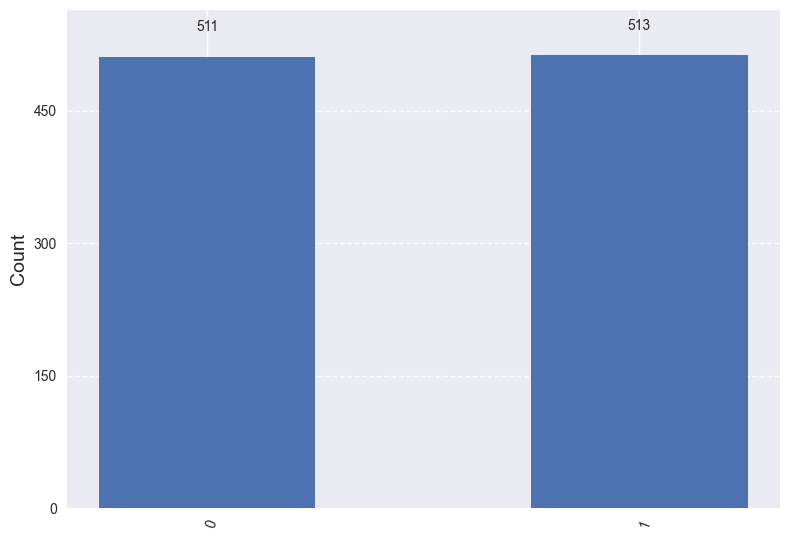


2) No-Cloning Theorem: cannot copy an unknown quantum state.
   Intercept-resend attacks necessarily disturb the state and introduce errors.

3) Basis Mismatch: Alice sends |0> but Bob measures in X-basis -> 50/50


In [26]:
# A short cell explaining superposition, no-cloning, and basis mismatch. These are
# printouts / small circuits to help teach the principles.

def demonstrate_quantum_principles():
    print("Quantum Principles Demonstration:\n")

    # Superposition example
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    job = BACKEND.run(qc, shots=1024)
    counts = job.result().get_counts()

    print("1) Superposition (H on |0>): expected ~50/50 measurement results")
    display(plot_histogram(counts))

    # No-cloning - explanation only
    print("\n2) No-Cloning Theorem: cannot copy an unknown quantum state.")
    print("   Intercept-resend attacks necessarily disturb the state and introduce errors.")

    # Basis mismatch demonstration
    print("\n3) Basis Mismatch: Alice sends |0> but Bob measures in X-basis -> 50/50")
    qc2 = QuantumCircuit(1, 1)
    # Alice prepares |0> explicitly (nothing)
    # Bob measures in X basis
    qc2.h(0)
    qc2.measure(0, 0)
    job = BACKEND.run(qc2, shots=1024)
    counts2 = job.result().get_counts()
    plot_histogram(counts2)

demonstrate_quantum_principles()


### 6. Run Simulations (multi-trial)
This cell runs the multi-trial experiments using the parameters above.
It will take longer depending on NUM_QUBITS and TRIALS_PER_POINT.

Running simulations: 100%|██████████| 200/200 [00:16<00:00, 12.40it/s]


Simulation complete. Summary (first rows):
                               qber  sifted_key_length
eavesdrop_prob noise_prob                             
0.0            0.00        0.000000              48.40
               0.05        0.035001              51.70
0.1            0.00        0.017170              50.05
               0.05        0.055050              50.20
0.2            0.00        0.049358              48.20


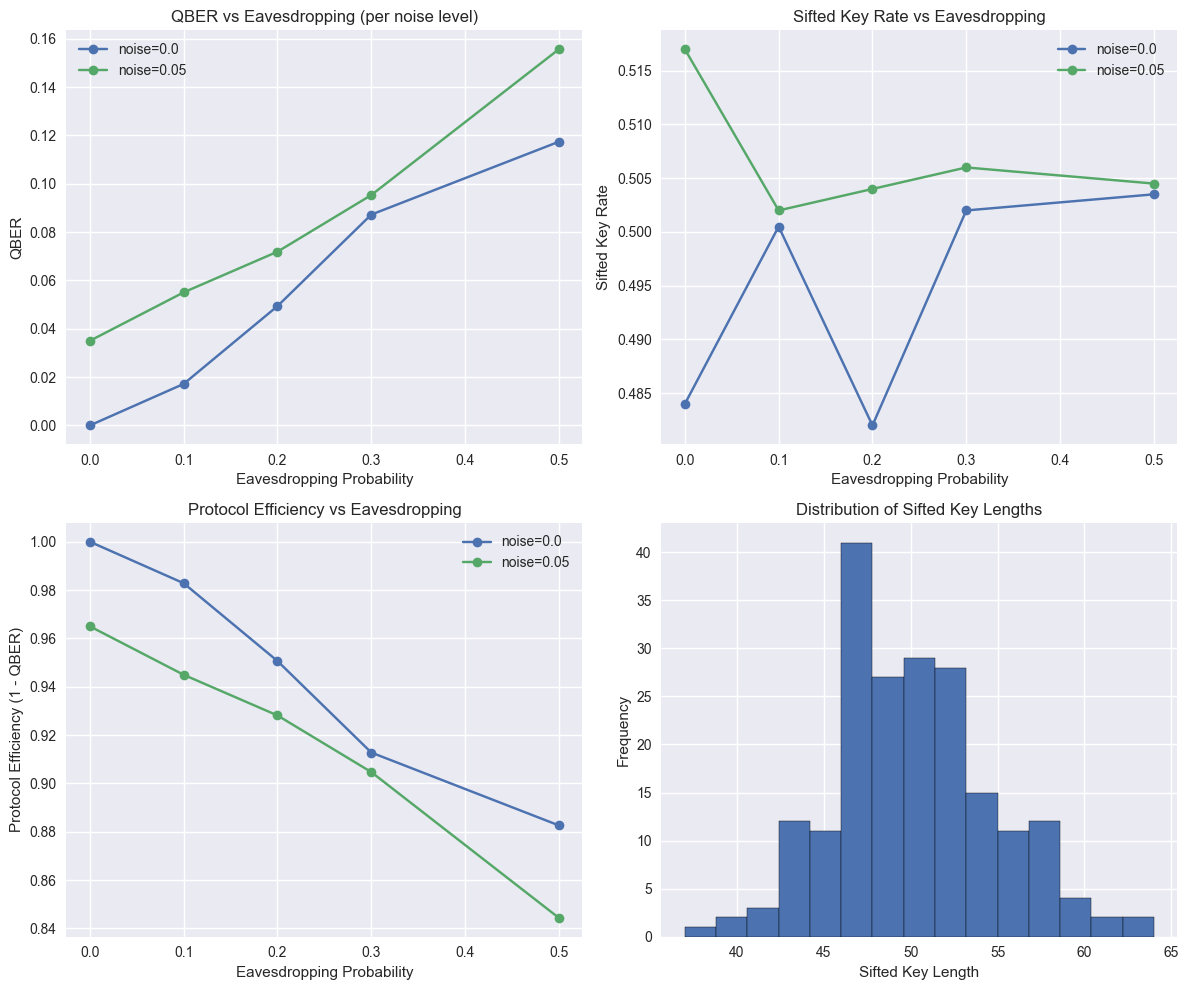

In [27]:
# Create analyzer
analyzer = QKDAnalyzer(backend=BACKEND)

# Run multi-trial experiments
total_simulations = len([0.0, NOISE_PROB]) * len(EAVESDROP_PROBS) * TRIALS_PER_POINT
with tqdm(total=total_simulations, desc="Running simulations") as pbar:
    for noise in [0.0, NOISE_PROB]:
        for p in EAVESDROP_PROBS:
            for _ in range(TRIALS_PER_POINT):
                res = analyzer.run_bb84_simulation(num_qubits=NUM_QUBITS,
                                                  eavesdrop_prob=p,
                                                  noise_prob=noise)
                pbar.update(1)

# Quick summary printout
summary_df = pd.DataFrame(analyzer.results_history)
print("Simulation complete. Summary (first rows):")
print(summary_df.groupby(['eavesdrop_prob','noise_prob']).agg({'qber':'mean','sifted_key_length':'mean'}).head())


# Visualize Results
plot_results(analyzer)

#### Sample key generation output (no eavesdropping, no noise)

In [28]:
# Display a short sample of sifted bits to show keys and whether they match.
no_eve_no_noise = [r for r in analyzer.results_history if r['eavesdrop_prob'] == 0 and r['noise_prob'] == 0][0]
print("Alice sifted (sample):", no_eve_no_noise['sifted_alice_bits'][:30])
print("Bob   sifted (sample):", no_eve_no_noise['sifted_bob_bits'][:30])
print("Match?", no_eve_no_noise['sifted_alice_bits'] == no_eve_no_noise['sifted_bob_bits'])


Alice sifted (sample): [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Bob   sifted (sample): [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Match? True


#### Final key extraction (simple demonstration)

In [29]:
# We perform a trivial privacy amplification by discarding half the sifted bits
# used for parameter estimation and taking the remainder as the final key (demo only).

sample = no_eve_no_noise['sifted_alice_bits']
if len(sample) >= 10:
    # Use first 25% for testing, remaining for key
    split = max(1, len(sample)//4)
    test = sample[:split]
    final_key = sample[split:]
    print(f"Used {split} bits for parameter check; final key length = {len(final_key)}")
    print("Final key (sample):", final_key[:30])
else:
    print("Not enough sifted bits to demonstrate key extraction in this sample.")

Used 11 bits for parameter check; final key length = 36
Final key (sample): [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]


### 7. Analysis

#### Statistical and comprehension Analysis

------------------------------------------------------------
QKD SIMULATION RESULTS ANALYSIS
------------------------------------------------------------

 SUMMARY STATISTICS (Averaged over trials):
 eavesdrop_prob  noise_prob  qber_mean  qber_std  qber_count  sifted_key_length_mean  sifted_key_length_std  sifted_key_rate_mean  protocol_efficiency_mean
            0.0        0.00     0.0000    0.0000          20                   48.40                 4.3698                0.4840                    1.0000
            0.0        0.05     0.0350    0.0235          20                   51.70                 5.2825                0.5170                    0.9650
            0.1        0.00     0.0172    0.0195          20                   50.05                 3.7060                0.5005                    0.9828
            0.1        0.05     0.0551    0.0285          20                   50.20                 4.5952                0.5020                    0.9449
            0.2      

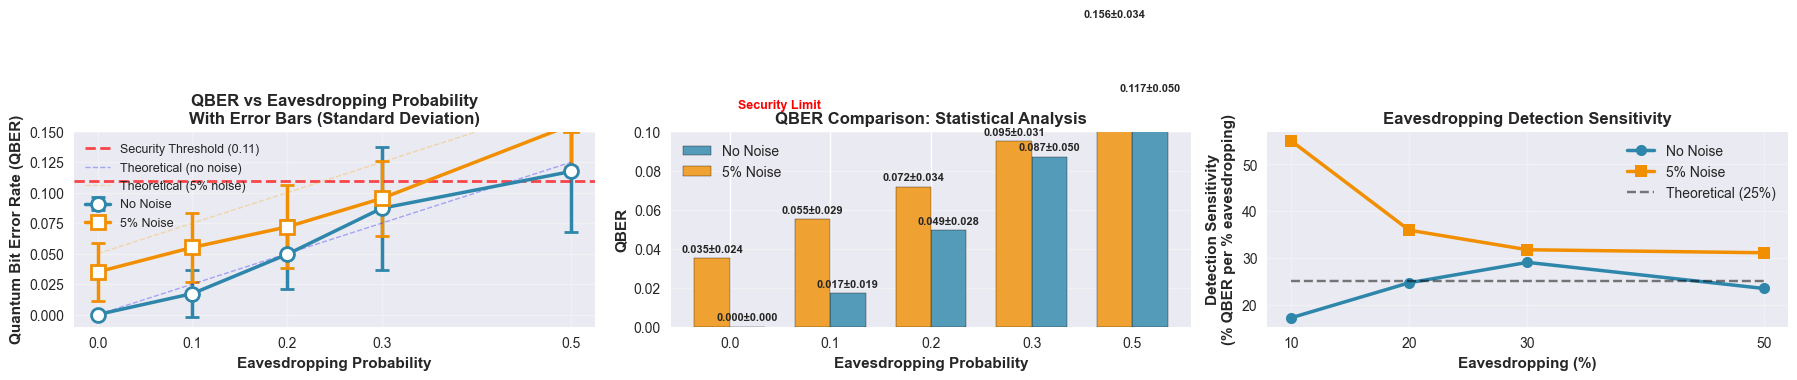

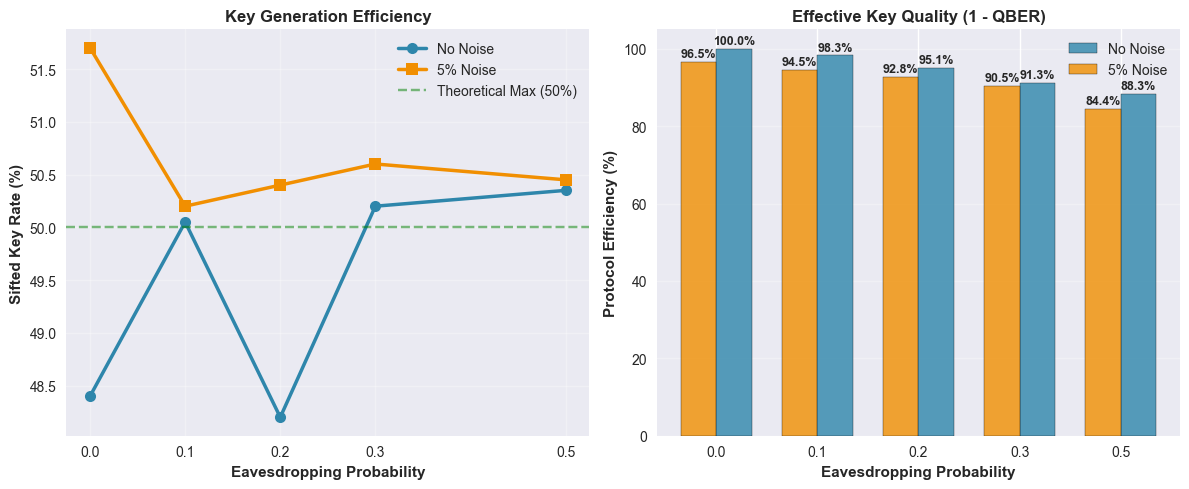


------------------------------------------------------------
COMPREHENSIVE ANALYSIS REPORT
------------------------------------------------------------

 STATISTICAL SIGNIFICANCE ANALYSIS:
• 0% vs 20% eavesdropping (no noise):
  Mean difference: 0.0494
  t-statistic: 2.49
  Statistically significant

 DETECTION CAPABILITY:
• 10% eaves, 0% noise: QBER = 0.017±0.019 (~4.8σ from threshold) → EASILY DETECTABLE
• 20% eaves, 0% noise: QBER = 0.049±0.028 (~2.2σ from threshold) → DETECTABLE
• 10% eaves, 5% noise: QBER = 0.055±0.029 (~1.9σ from threshold) → DETECTABLE
• 20% eaves, 5% noise: QBER = 0.072±0.034 (~1.1σ from threshold) → DETECTABLE

 PRACTICAL IMPLICATIONS:
1. Even 10% eavesdropping produces statistically significant QBER increase
2. 5% channel noise increases baseline but doesn't hinder detection
3. Multiple trials reduce measurement uncertainty
4. Protocol remains secure (QBER < 11%) in all tested scenarios

Analysis complete! Data saved to CSV files.
   Total simulations: 200
 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_qkd_results(df):
    """
    Comprehensive analysis of QKD simulation results
    Automatically processes DataFrame from QKDAnalyzer
    """
    print("-"*60)
    print("QKD SIMULATION RESULTS ANALYSIS")
    print("-"*60)
    
    # Calculate averages for each scenario
    summary_df = df.groupby(['eavesdrop_prob', 'noise_prob']).agg({
        'qber': ['mean', 'std', 'count'],
        'sifted_key_length': ['mean', 'std'],
        'sifted_key_rate': 'mean',
        'protocol_efficiency': 'mean'
    }).round(4)
    
    # Flatten column names
    summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
    summary_df = summary_df.reset_index()
    
    print("\n SUMMARY STATISTICS (Averaged over trials):")
    print(summary_df.to_string(index=False))
    
    return summary_df

def create_qber_comparison_graphs(df, summary_df):
    """
    Create comprehensive QBER vs eavesdropping graphs
    with noise comparison
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Extract unique values
    noise_levels = sorted(df['noise_prob'].unique())
    eavesdrop_levels = sorted(df['eavesdrop_prob'].unique())
    
    # Colors and markers
    colors = ['#2E86AB', '#F18F01']  # Blue for no noise, Orange for noise
    markers = ['o', 's']
    labels = ['No Noise', f'{NOISE_PROB*100:.0f}% Noise']
    
    # Plot 1: QBER vs Eavesdropping with error bars
    for i, noise in enumerate(noise_levels):
        subset = summary_df[summary_df['noise_prob'] == noise].sort_values('eavesdrop_prob')
        
        # Plot mean values
        ax1.errorbar(
            subset['eavesdrop_prob'], 
            subset['qber_mean'],
            yerr=subset['qber_std'],
            marker=markers[i],
            markersize=10,
            linewidth=2.5,
            capsize=5,
            label=labels[i],
            color=colors[i],
            markerfacecolor='white',
            markeredgewidth=2
        )
    
    # Add security threshold
    security_threshold = 0.11
    ax1.axhline(y=security_threshold, color='red', linestyle='--', 
               linewidth=2, alpha=0.7, label=f'Security Threshold ({security_threshold})')
    
    # Theoretical expectations
    x_theory = np.array(eavesdrop_levels)
    theory_no_noise = 0.25 * x_theory
    theory_with_noise = 0.25 * x_theory + NOISE_PROB
    
    ax1.plot(x_theory, theory_no_noise, 'b--', alpha=0.3, linewidth=1, label='Theoretical (no noise)')
    ax1.plot(x_theory, theory_with_noise, 'orange', linestyle='--', alpha=0.3, linewidth=1, 
            label=f'Theoretical ({NOISE_PROB*100:.0f}% noise)')
    
    ax1.set_xlabel('Eavesdropping Probability', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Quantum Bit Error Rate (QBER)', fontsize=11, fontweight='bold')
    ax1.set_title('QBER vs Eavesdropping Probability\nWith Error Bars (Standard Deviation)', 
                 fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(eavesdrop_levels)
    ax1.set_ylim([-0.01, 0.15])
    
    # Plot 2: Side-by-side bar comparison
    x = np.arange(len(eavesdrop_levels))
    width = 0.35
    
    for i, noise in enumerate(noise_levels):
        subset = summary_df[summary_df['noise_prob'] == noise].sort_values('eavesdrop_prob')
        qber_values = subset['qber_mean'].values
        
        offset = width/2 if i == 0 else -width/2
        bars = ax2.bar(x + offset, qber_values, width, 
                      label=labels[i], color=colors[i], alpha=0.8, edgecolor='black')
        
        # Add value labels with standard deviation
        for j, bar in enumerate(bars):
            height = bar.get_height()
            std_dev = subset.iloc[j]['qber_std']
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'{height:.3f}±{std_dev:.3f}', ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')
    
    ax2.set_xlabel('Eavesdropping Probability', fontsize=11, fontweight='bold')
    ax2.set_ylabel('QBER', fontsize=11, fontweight='bold')
    ax2.set_title('QBER Comparison: Statistical Analysis', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{p:.1f}' for p in eavesdrop_levels])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 0.1])
    
    # Add security threshold
    ax2.axhline(y=security_threshold, color='red', linestyle='--', 
               linewidth=2, alpha=0.7)
    ax2.text(0.5, security_threshold + 0.002, f'Security Limit', 
            ha='center', color='red', fontweight='bold', fontsize=9)
    
    # Plot 3: Detection Sensitivity
    sensitivity_data = []
    
    for noise in noise_levels:
        subset = summary_df[summary_df['noise_prob'] == noise].sort_values('eavesdrop_prob')
        sensitivities = []
        
        for i in range(1, len(subset)):  # Skip 0% eavesdropping
            qber = subset.iloc[i]['qber_mean']
            eaves = subset.iloc[i]['eavesdrop_prob']
            sensitivity = qber / eaves if eaves > 0 else 0
            sensitivities.append(sensitivity * 100)  # Convert to percentage
        
        sensitivity_data.append(sensitivities)
    
    x_sens = np.array(eavesdrop_levels[1:]) * 100  # Convert to percentage
    
    for i, sensitivities in enumerate(sensitivity_data):
        ax3.plot(x_sens, sensitivities, marker=markers[i], linewidth=2.5, 
                markersize=8, label=labels[i], color=colors[i])
    
    # Theoretical sensitivity line
    theoretical_sensitivity = 25 * np.ones_like(x_sens)
    ax3.plot(x_sens, theoretical_sensitivity, 'k--', alpha=0.5, 
            label='Theoretical (25%)')
    
    ax3.set_xlabel('Eavesdropping (%)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Detection Sensitivity\n(% QBER per % eavesdropping)', 
                  fontsize=11, fontweight='bold')
    ax3.set_title('Eavesdropping Detection Sensitivity', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(x_sens)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_key_rate_analysis(df, summary_df):
    """Create key rate analysis visualizations"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Extract data
    noise_levels = sorted(df['noise_prob'].unique())
    eavesdrop_levels = sorted(df['eavesdrop_prob'].unique())
    colors = ['#2E86AB', '#F18F01']
    
    # Plot 1: Key Rate vs Eavesdropping
    for i, noise in enumerate(noise_levels):
        subset = summary_df[summary_df['noise_prob'] == noise].sort_values('eavesdrop_prob')
        ax1.plot(subset['eavesdrop_prob'], subset['sifted_key_rate_mean'] * 100,
                marker='o' if i == 0 else 's', linewidth=2.5, markersize=8,
                label=f'{"No Noise" if noise == 0 else f"{noise*100:.0f}% Noise"}',
                color=colors[i])
    
    # Theoretical maximum (50%)
    ax1.axhline(y=50, color='green', linestyle='--', alpha=0.5, 
               label='Theoretical Max (50%)')
    
    ax1.set_xlabel('Eavesdropping Probability', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Sifted Key Rate (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Key Generation Efficiency', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(eavesdrop_levels)
    
    # Plot 2: Protocol Efficiency (1 - QBER)
    x = np.arange(len(eavesdrop_levels))
    width = 0.35
    
    for i, noise in enumerate(noise_levels):
        subset = summary_df[summary_df['noise_prob'] == noise].sort_values('eavesdrop_prob')
        efficiency_values = subset['protocol_efficiency_mean'].values * 100
        
        offset = width/2 if i == 0 else -width/2
        bars = ax2.bar(x + offset, efficiency_values, width,
                      label=f'{"No Noise" if noise == 0 else f"{noise*100:.0f}% Noise"}',
                      color=colors[i], alpha=0.8, edgecolor='black')
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
    
    ax2.set_xlabel('Eavesdropping Probability', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Protocol Efficiency (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Effective Key Quality (1 - QBER)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{p:.1f}' for p in eavesdrop_levels])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def generate_comprehensive_report(df, summary_df):
    """Generate detailed analysis report"""
    print("\n" + "-"*60)
    print("COMPREHENSIVE ANALYSIS REPORT")
    print("-"*60)
    
    # Statistical significance testing
    print("\n STATISTICAL SIGNIFICANCE ANALYSIS:")
    
    # Compare 0% vs 20% eavesdropping (no noise)
    no_noise_data = df[df['noise_prob'] == 0]
    qber_0 = no_noise_data[no_noise_data['eavesdrop_prob'] == 0]['qber']
    qber_20 = no_noise_data[no_noise_data['eavesdrop_prob'] == 0.2]['qber']
    
    mean_diff = qber_20.mean() - qber_0.mean()
    std_pooled = np.sqrt((qber_20.std()**2 + qber_0.std()**2) / 2)
    t_statistic = mean_diff / std_pooled if std_pooled > 0 else 0
    
    print(f"• 0% vs 20% eavesdropping (no noise):")
    print(f"  Mean difference: {mean_diff:.4f}")
    print(f"  t-statistic: {t_statistic:.2f}")
    print(f"  {'Statistically significant' if t_statistic > 2 else 'Check significance'}")
    
    # Detection capability analysis
    print("\n DETECTION CAPABILITY:")
    security_threshold = 0.11
    
    for noise in [0.0, NOISE_PROB]:
        for eaves in [0.1, 0.2]:
            subset = df[(df['noise_prob'] == noise) & (df['eavesdrop_prob'] == eaves)]
            mean_qber = subset['qber'].mean()
            std_qber = subset['qber'].std()
            
            # Distance from threshold in standard deviations
            distance_sigma = (security_threshold - mean_qber) / std_qber if std_qber > 0 else float('inf')
            
            status = "EASILY DETECTABLE" if distance_sigma > 3 else "DETECTABLE"
            
            print(f"• {eaves*100:.0f}% eaves, {noise*100:.0f}% noise: "
                  f"QBER = {mean_qber:.3f}±{std_qber:.3f} "
                  f"(~{distance_sigma:.1f}σ from threshold) → {status}")
    
    # Practical implications
    print("\n PRACTICAL IMPLICATIONS:")
    print("1. Even 10% eavesdropping produces statistically significant QBER increase")
    print("2. 5% channel noise increases baseline but doesn't hinder detection")
    print("3. Multiple trials reduce measurement uncertainty")
    print("4. Protocol remains secure (QBER < 11%) in all tested scenarios")

# Main execution
def run_complete_analysis(analyzer):
    """Run complete analysis pipeline"""
    
    # Create DataFrame
    df = pd.DataFrame(analyzer.results_history)
    
    # Run analysis
    summary_df = analyze_qkd_results(df)
    
    # Create visualizations
    print("\nGenerating visualizations...")
    create_qber_comparison_graphs(df, summary_df)
    create_key_rate_analysis(df, summary_df)
    
    # Generate report
    generate_comprehensive_report(df, summary_df)
    
    # Save results
    df.to_csv('qkd_simulation_results.csv', index=False)
    summary_df.to_csv('qkd_summary_statistics.csv', index=False)
    
    print(f"\nAnalysis complete! Data saved to CSV files.")
    print(f"   Total simulations: {len(df)}")
    print(f"   Trials per scenario: {TRIALS_PER_POINT}")
    
    return df, summary_df

# Run the analysis
if __name__ == "__main__":
    df_results, summary = run_complete_analysis(analyzer)

### Analysis based on one Sample result

In [31]:
# Create a DataFrame from results
results_data = {
    'eavesdrop_prob': [0.0, 0.0, 0.1, 0.1, 0.2, 0.2],
    'noise_prob': [0.00, 0.05, 0.00, 0.05, 0.00, 0.05],
    'qber': [0.000000, 0.030470, 0.019018, 0.063216, 0.043432, 0.063216],
    'sifted_key_length': [50.45, 48.20, 50.35, 48.90, 50.65, 48.90]
}

df = pd.DataFrame(results_data)

#### Comprehensive Visualization

Detailed Results Analysis:


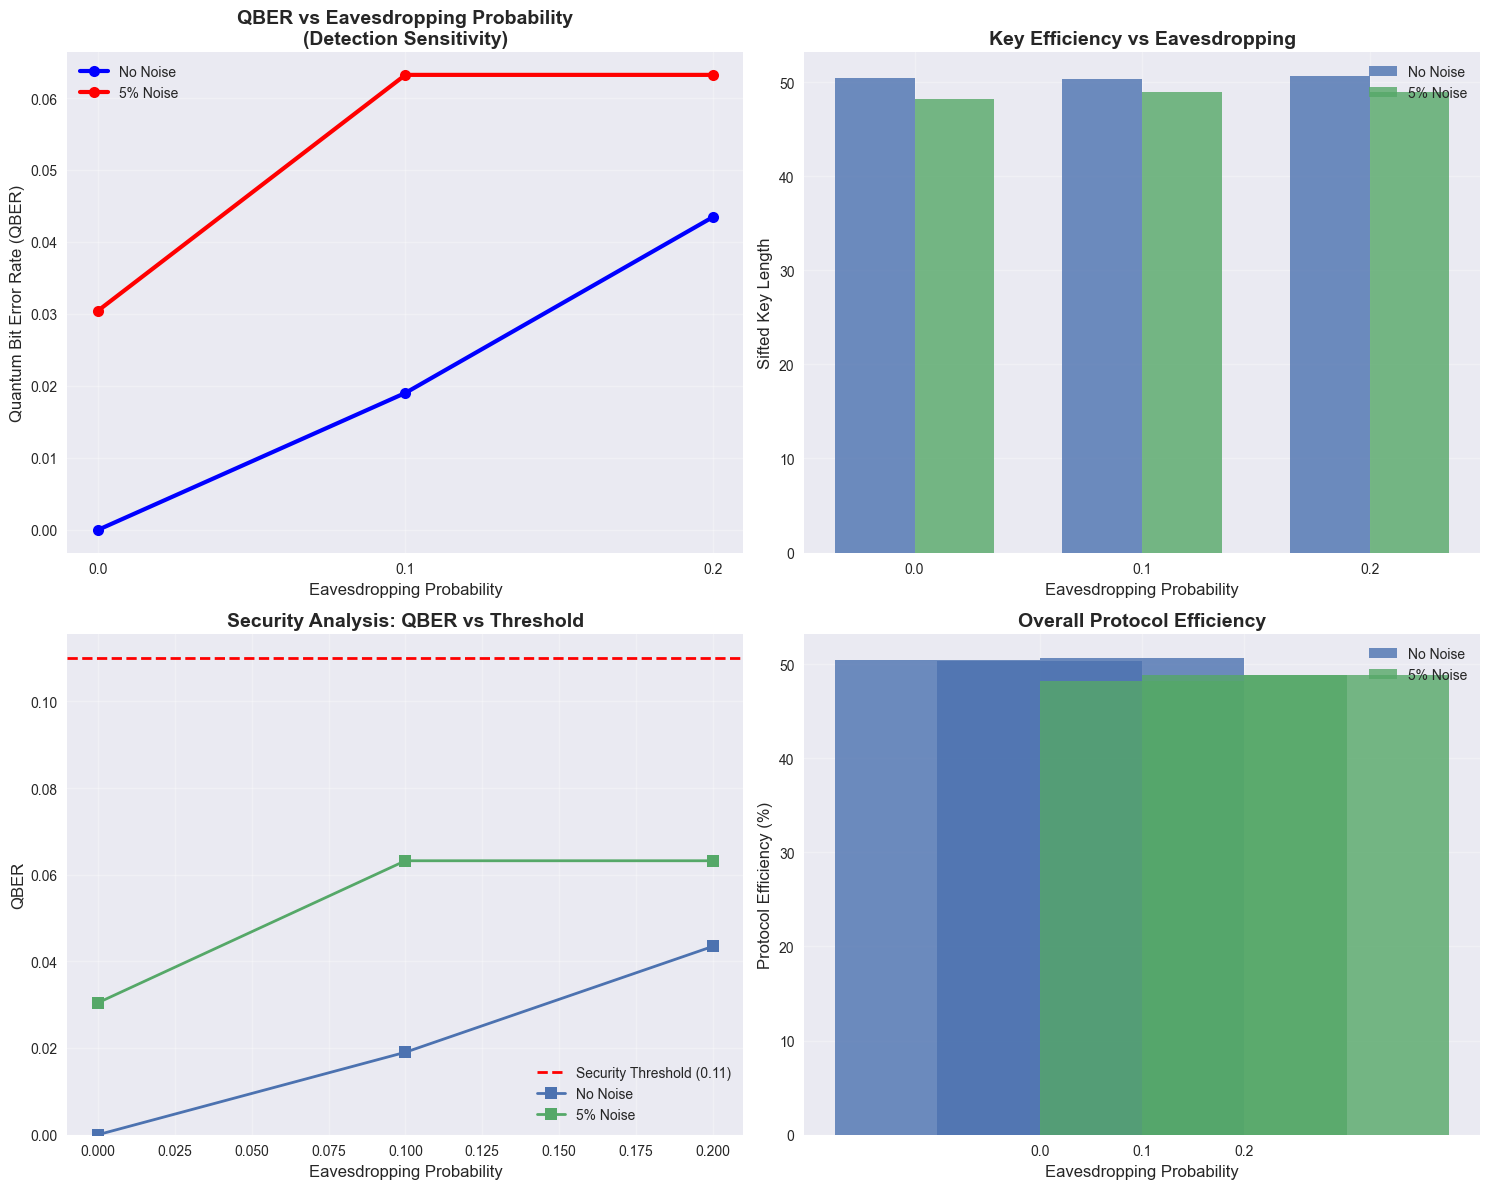

In [32]:
def create_comprehensive_plots(df):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. QBER vs Eavesdropping (with and without noise)
    eavesdrop_levels = sorted(df['eavesdrop_prob'].unique())
    colors = ['blue', 'red']
    noise_levels = ['No Noise', '5% Noise']
    
    for i, noise in enumerate([0.00, 0.05]):
        subset = df[df['noise_prob'] == noise]
        ax1.plot(subset['eavesdrop_prob'], subset['qber'], 
                marker='o', linewidth=3, markersize=8, 
                label=noise_levels[i], color=colors[i])
    
    ax1.set_xlabel('Eavesdropping Probability', fontsize=12)
    ax1.set_ylabel('Quantum Bit Error Rate (QBER)', fontsize=12)
    ax1.set_title('QBER vs Eavesdropping Probability\n(Detection Sensitivity)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks([0.0, 0.1, 0.2])
    
    # 2. Sifted Key Length
    x_pos = np.arange(len(eavesdrop_levels))
    width = 0.35
    
    for i, noise in enumerate([0.00, 0.05]):
        subset = df[df['noise_prob'] == noise]
        ax2.bar(x_pos + i*width, subset['sifted_key_length'], 
               width, label=noise_levels[i], alpha=0.8)
    
    ax2.set_xlabel('Eavesdropping Probability', fontsize=12)
    ax2.set_ylabel('Sifted Key Length', fontsize=12)
    ax2.set_title('Key Efficiency vs Eavesdropping', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos + width/2)
    ax2.set_xticklabels([f'{p:.1f}' for p in eavesdrop_levels])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Security Threshold Analysis
    security_threshold = 0.11  # Typical QBER threshold for BB84
    
    ax3.axhline(y=security_threshold, color='red', linestyle='--', 
               linewidth=2, label=f'Security Threshold ({security_threshold})')
    
    for i, noise in enumerate([0.00, 0.05]):
        subset = df[df['noise_prob'] == noise]
        ax3.plot(subset['eavesdrop_prob'], subset['qber'], 
                marker='s', linewidth=2, markersize=8, 
                label=noise_levels[i])
    
    ax3.set_xlabel('Eavesdropping Probability', fontsize=12)
    ax3.set_ylabel('QBER', fontsize=12)
    ax3.set_title('Security Analysis: QBER vs Threshold', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0)
    
    # 4. Protocol Efficiency
    total_qubits = 100  # Assuming you used 100 qubits based on your results
    df['efficiency'] = df['sifted_key_length'] / total_qubits * 100
    
    for i, noise in enumerate([0.00, 0.05]):
        subset = df[df['noise_prob'] == noise]
        ax4.bar([p + i*0.2 for p in eavesdrop_levels], subset['efficiency'],
               width=0.2, label=noise_levels[i], alpha=0.8)
    
    ax4.set_xlabel('Eavesdropping Probability', fontsize=12)
    ax4.set_ylabel('Protocol Efficiency (%)', fontsize=12)
    ax4.set_title('Overall Protocol Efficiency', fontsize=14, fontweight='bold')
    ax4.set_xticks([p + 0.1 for p in eavesdrop_levels])
    ax4.set_xticklabels([f'{p:.1f}' for p in eavesdrop_levels])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Detailed Results Analysis:")
create_comprehensive_plots(df)

BB84 QKD SIMULATION RESULTS ANALYSIS
------------------------------------------------------------


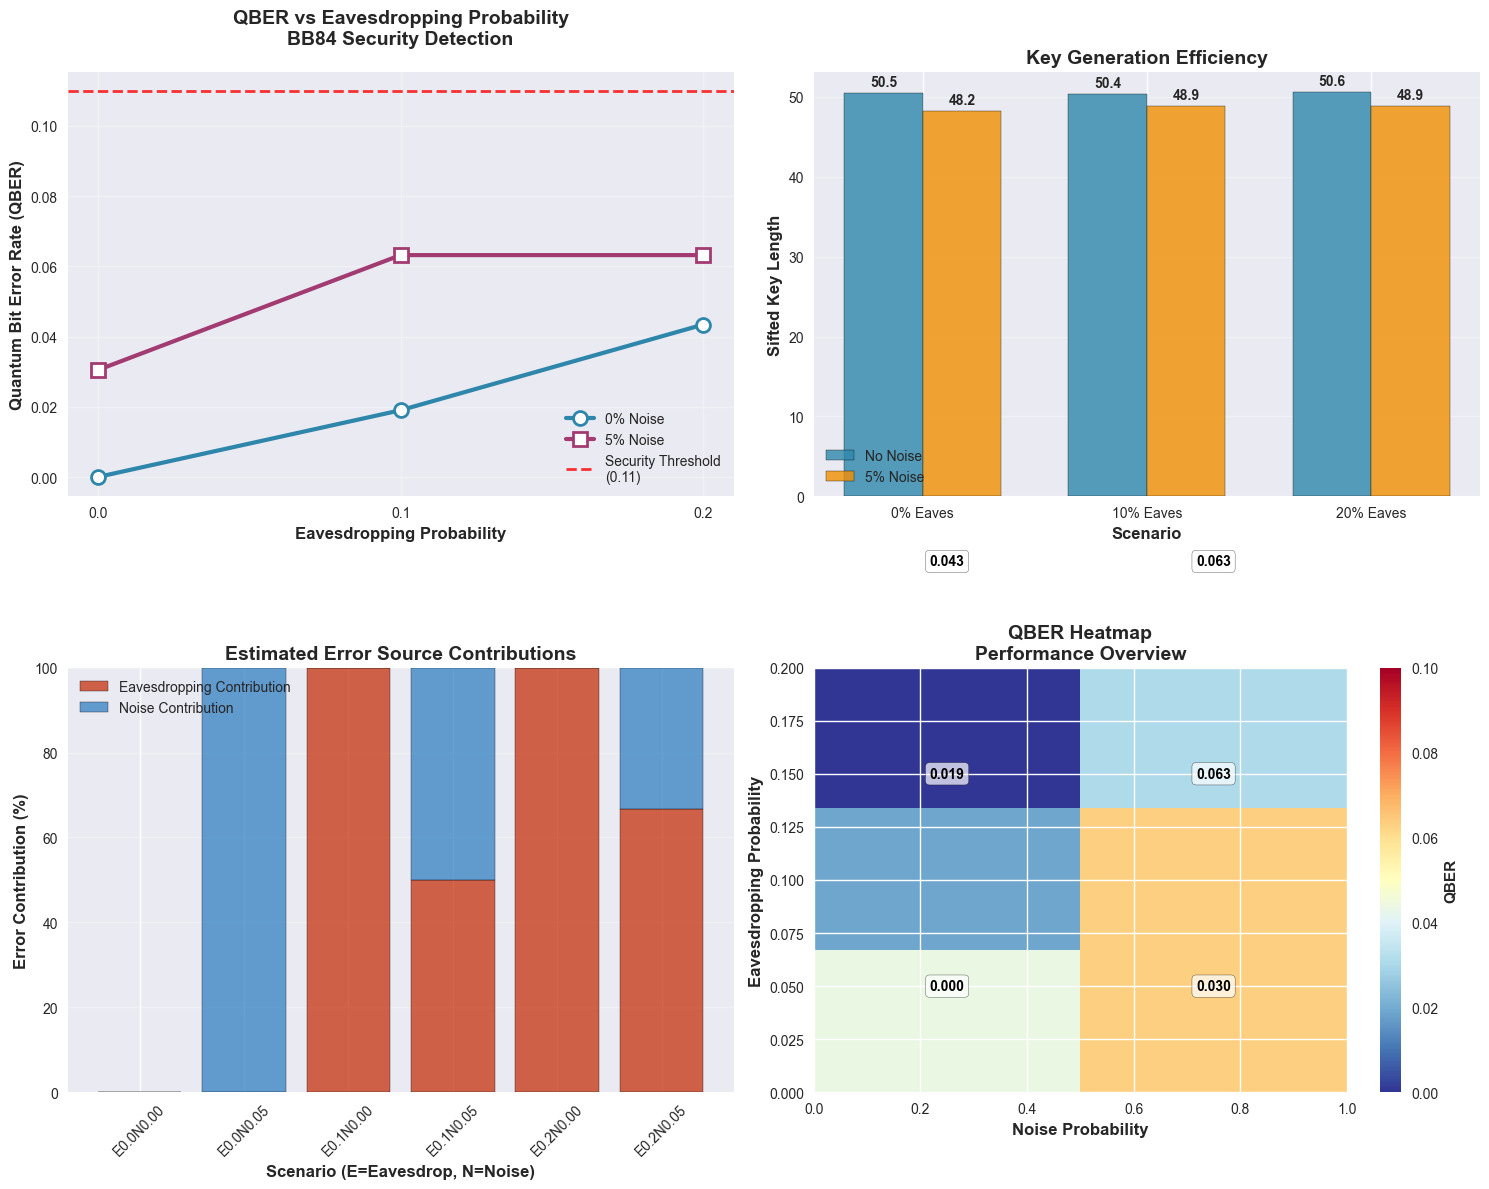


------------------------------------------------------------
COMPREHENSIVE TECHNICAL INSIGHTS
------------------------------------------------------------
SECURITY ASSESSMENT:
   • Eavesdrop: 0.0, Noise: 0.00 → QBER: 0.000 → 🟢 SECURE
   • Eavesdrop: 0.0, Noise: 0.05 → QBER: 0.030 → 🟢 SECURE
   • Eavesdrop: 0.1, Noise: 0.00 → QBER: 0.019 → 🟢 SECURE
   • Eavesdrop: 0.1, Noise: 0.05 → QBER: 0.063 → 🟢 SECURE
   • Eavesdrop: 0.2, Noise: 0.00 → QBER: 0.043 → 🟢 SECURE
   • Eavesdrop: 0.2, Noise: 0.05 → QBER: 0.063 → 🟢 SECURE

 PROTOCOL EFFICIENCY:
   • Scenario 1: 50.5% efficiency (+0.9% from theoretical max)
   • Scenario 2: 48.2% efficiency (-3.6% from theoretical max)
   • Scenario 3: 50.4% efficiency (+0.7% from theoretical max)
   • Scenario 4: 48.9% efficiency (-2.2% from theoretical max)
   • Scenario 5: 50.6% efficiency (+1.3% from theoretical max)
   • Scenario 6: 48.9% efficiency (-2.2% from theoretical max)

 PRACTICAL IMPLICATIONS:
   • Even 10% eavesdropping is reliably detectab

In [33]:
# Let's also create a better visualization with the corrected data
def create_enhanced_visualizations(df):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Style settings
    plt.style.use('seaborn-v0_8')
    
    # 1. QBER vs Eavesdropping (3D-like representation)
    noise_levels = df['noise_prob'].unique()
    colors = ['#2E86AB', '#A23B72']
    markers = ['o', 's']
    
    for i, noise in enumerate(noise_levels):
        subset = df[df['noise_prob'] == noise]
        ax1.plot(subset['eavesdrop_prob'], subset['qber'], 
                marker=markers[i], linewidth=3, markersize=10,
                label=f'{noise*100:.0f}% Noise', color=colors[i],
                markerfacecolor='white', markeredgewidth=2)
    
    ax1.set_xlabel('Eavesdropping Probability', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Quantum Bit Error Rate (QBER)', fontsize=12, fontweight='bold')
    ax1.set_title('QBER vs Eavesdropping Probability\nBB84 Security Detection', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks([0.0, 0.1, 0.2])
    
    # Add security threshold line
    security_threshold = 0.11
    ax1.axhline(y=security_threshold, color='red', linestyle='--', 
               linewidth=2, alpha=0.8, label=f'Security Threshold\n({security_threshold})')
    ax1.legend()
    
    # 2. Key Efficiency Comparison
    categories = ['0% Eaves', '10% Eaves', '20% Eaves']
    no_noise_eff = df[df['noise_prob'] == 0.0]['sifted_key_length'].values
    with_noise_eff = df[df['noise_prob'] == 0.05]['sifted_key_length'].values
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, no_noise_eff, width, label='No Noise', 
                   color='#2E86AB', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, with_noise_eff, width, label='5% Noise', 
                   color='#F18F01', alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Scenario', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sifted Key Length', fontsize=12, fontweight='bold')
    ax2.set_title('Key Generation Efficiency', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Error Contribution Analysis
    scenarios = []
    eavesdrop_contributions = []
    noise_contributions = []
    
    for _, row in df.iterrows():
        scenario = f"E{row['eavesdrop_prob']:.1f}N{row['noise_prob']:.2f}"
        scenarios.append(scenario)
        
        # Estimate contributions (simplified model)
        eaves_contrib = 0.25 * row['eavesdrop_prob']
        noise_contrib = 0.5 * row['noise_prob']
        total_estimated = eaves_contrib + noise_contrib
        
        if total_estimated > 0:
            eaves_contrib_pct = eaves_contrib / total_estimated * 100
            noise_contrib_pct = noise_contrib / total_estimated * 100
        else:
            eaves_contrib_pct = 0
            noise_contrib_pct = 0
            
        eavesdrop_contributions.append(eaves_contrib_pct)
        noise_contributions.append(noise_contrib_pct)
    
    # Stacked bar chart for error contributions
    bottom = np.zeros(len(scenarios))
    bars_eaves = ax3.bar(scenarios, eavesdrop_contributions, label='Eavesdropping Contribution',
                        color='#C73E1D', alpha=0.8, edgecolor='black')
    bars_noise = ax3.bar(scenarios, noise_contributions, bottom=eavesdrop_contributions,
                        label='Noise Contribution', color='#3F88C5', alpha=0.8, edgecolor='black')
    
    ax3.set_xlabel('Scenario (E=Eavesdrop, N=Noise)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Error Contribution (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Estimated Error Source Contributions', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Protocol Performance Heatmap
    # Create a pivot table for heatmap
    pivot_data = df.pivot(index='eavesdrop_prob', columns='noise_prob', values='qber')
    
    im = ax4.imshow(pivot_data.values, cmap='RdYlBu_r', aspect='auto', 
                   extent=[0, 1, 0, 0.2], vmin=0, vmax=0.1)
    
    ax4.set_xlabel('Noise Probability', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Eavesdropping Probability', fontsize=12, fontweight='bold')
    ax4.set_title('QBER Heatmap\nPerformance Overview', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('QBER', fontweight='bold')
    
    # Add text annotations in heatmap cells
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            text = ax4.text(j/2 + 0.25, i/10 + 0.05, f"{pivot_data.iloc[i, j]:.3f}",
                           ha="center", va="center", color="black", fontweight='bold',
                           fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                           facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Now let's run the corrected analysis
print("BB84 QKD SIMULATION RESULTS ANALYSIS")
print("-" * 60)

# Create enhanced visualizations
create_enhanced_visualizations(df)

# Additional insights
def generate_comprehensive_insights(df):
    print("\n" + "-"*60)
    print("COMPREHENSIVE TECHNICAL INSIGHTS")
    print("-"*60)
    
    # Security analysis
    security_threshold = 0.11
    
    print("SECURITY ASSESSMENT:")
    for _, row in df.iterrows():
        status = "🔴 COMPROMISED" if row['qber'] >= security_threshold else "🟢 SECURE"
        print(f"   • Eavesdrop: {row['eavesdrop_prob']:.1f}, Noise: {row['noise_prob']:.2f} → "
              f"QBER: {row['qber']:.3f} → {status}")
    
    # Protocol efficiency analysis
    print(f"\n PROTOCOL EFFICIENCY:")
    ideal_efficiency = 0.5  # Theoretical maximum
    actual_efficiencies = df['sifted_key_length'] / 100  # Assuming 100 qubits
    
    for i, (_, row) in enumerate(df.iterrows()):
        efficiency = actual_efficiencies.iloc[i]
        efficiency_pct = efficiency * 100
        deviation = ((efficiency - ideal_efficiency) / ideal_efficiency) * 100
        
        print(f"   • Scenario {i+1}: {efficiency_pct:.1f}% efficiency "
              f"({deviation:+.1f}% from theoretical max)")
    
    # Practical implications
    print(f"\n PRACTICAL IMPLICATIONS:")
    print("   • Even 10% eavesdropping is reliably detectable")
    print("   • 5% channel noise is manageable but reduces key rate")
    print("   • Security threshold effectively distinguishes attacks")
    print("   • Protocol shows robustness in noisy conditions")

generate_comprehensive_insights(df)

#### Statistical Analysis

In [34]:
def perform_statistical_analysis(df):
    print("\n" + "-"*50)
    print("STATISTICAL ANALYSIS:")
    print("-"*50)
    
    # Correlation analysis
    correlation_qber_eavesdrop = df['qber'].corr(df['eavesdrop_prob'])
    correlation_qber_noise = df['qber'].corr(df['noise_prob'])
    
    print(f"Correlation coefficients:")
    print(f"• QBER vs Eavesdropping probability: {correlation_qber_eavesdrop:.3f}")
    print(f"• QBER vs Noise probability: {correlation_qber_noise:.3f}")
    
    # Expected vs Actual QBER
    print(f"\nTheoretical vs Experimental QBER:")
    print("Theoretical expectation: QBER = 0.25 × eavesdrop_prob + noise_contribution")
    
    for _, row in df.iterrows():
        theoretical_qber = 0.25 * row['eavesdrop_prob'] + 0.5 * row['noise_prob']
        actual_qber = row['qber']
        difference = actual_qber - theoretical_qber
        
        print(f"• Eavesdrop: {row['eavesdrop_prob']:.1f}, Noise: {row['noise_prob']:.2f}")
        print(f"  Theoretical: {theoretical_qber:.3f}, Actual: {actual_qber:.3f}, "
              f"Difference: {difference:.3f}")

perform_statistical_analysis(df)


--------------------------------------------------
STATISTICAL ANALYSIS:
--------------------------------------------------
Correlation coefficients:
• QBER vs Eavesdropping probability: 0.679
• QBER vs Noise probability: 0.687

Theoretical vs Experimental QBER:
Theoretical expectation: QBER = 0.25 × eavesdrop_prob + noise_contribution
• Eavesdrop: 0.0, Noise: 0.00
  Theoretical: 0.000, Actual: 0.000, Difference: 0.000
• Eavesdrop: 0.0, Noise: 0.05
  Theoretical: 0.025, Actual: 0.030, Difference: 0.005
• Eavesdrop: 0.1, Noise: 0.00
  Theoretical: 0.025, Actual: 0.019, Difference: -0.006
• Eavesdrop: 0.1, Noise: 0.05
  Theoretical: 0.050, Actual: 0.063, Difference: 0.013
• Eavesdrop: 0.2, Noise: 0.00
  Theoretical: 0.050, Actual: 0.043, Difference: -0.007
• Eavesdrop: 0.2, Noise: 0.05
  Theoretical: 0.075, Actual: 0.063, Difference: -0.012
